In [5]:
import numpy as np
from numpy import log, pi, sqrt, exp
import matplotlib.pyplot as py
import emcee
from scipy.optimize import minimize
import corner

In this notebook I calculate the two parameters of a power law using both directly maximizing the likelihood function, as well as using an MCMC sampler. The specific application is the number of bursts with energy greater than some minimum value as a function of that value (i.e. the complementary cumlative energy distribution). 

$N_{bursts}(E>E_{min}) = A E_{min}^{\gamma} $

where $A$ is the number of bursts when $E_{min}=1$ and $\gamma$ is the power law index. 

The steps follow the tutorials on the emcee project page:
https://emcee.readthedocs.io/en/stable/tutorials/line/

The input data are either burst energies/fluences/whatever read from a text file or simulated values.

In [93]:
#Setup functions...(borrowed strongly from emcee tutorial)
# likelihood = prob of the data given a model
# prior = an intelligently chosen range of model parameters
# probability = prob of the parameters given the data
def log_likelihood(theta, E, N, errN):
    A,gamma = theta
    model = A*E**gamma
    sig2 = errN**2
    
    lh = -0.5*np.sum((N-model)**2/sig2 + log(sig2))
    return lh

def log_prior(theta):
    A, gamma = theta
    
    if gamma < 0 and A > 0:
        return 0
    else:
        return -np.inf
    
def log_probability(theta, E, N, errN):
    lp = log_prior(theta)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, E, N, errN)

def simulate_powlaw_energies(gamma, Nburst, E0):
    '''
    gamma = Index of the *differential* power law distribution
    Nburst = number of bursts to generate
    E0 = lower energy limit
    '''

    E_sim = E0*np.random.uniform(0,1, Nburst)**(1/(gamma))
    
    return E_sim

In [94]:
#Read from a file or simulate?
fromfile=False

#Parameters for simulated distribution
gamma=-1.1
Nburst=1000
E0=1 #erg

#Input file
filelist='/Users/lspitler/Research/mygit/PALFA/burst_lists/mary_fluences.txt'

if fromfile: # Load burst parameters from file    
    Fall=np.loadtxt(filelist, unpack=True)
else: # Or simulate a range of bursts
    Fall = simulate_powlaw_energies(gamma, Nburst, E0)

#Make cut in energy/fluence if desired
F_min=0
inds=np.where(Fall>F_min)[0]
F = Fall[inds]
Nb=F.shape[0]

#Sort fluences from high to low 
F=np.sort(F)[::-1]

#Make dummy array of number of bursts
N=np.arange(1, Nb+1, 1)

#Define error on the number (i.e. yerr)
#  either equal weightings (all 1) or standard error on the mean
#errN=1/sqrt(N)
errN=np.ones(Nb)

print("Num of bursts: %d" % F.shape[0])

Num of bursts: 1000


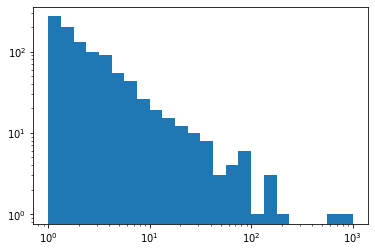

In [95]:
py.hist(F, bins=np.logspace(0, 3, 25))
py.xscale('log')
py.yscale('log')

In [97]:
#First calculate the parameters by directly maximizing the likelihood
nll = lambda *args: -log_likelihood(*args)

#These will need to be tailored to true data range to that they're somewhat close
guess=np.array([10, -0.9]) #[A, gamma]

#Brute force minimize
soln = minimize(nll, guess, args=(F, N, errN))
A_ml,g_ml=soln.x

print("Maximum likelihood estimates:")
print("A = {0:.3f}".format(A_ml))
print("gamma = {0:,.3f}".format(g_ml))

Maximum likelihood estimates:
A = 998.320
gamma = -1.081


In [98]:
#Estimate parameters using MCMC sampler with 32 walkers
nwalkers=32
ndim=2

# Set initial steps.
# Note, ranges may need to be manually adjusted depending on the power law data
p0 = np.zeros((nwalkers, ndim))
p0[:,0]=np.random.uniform(20,1000, size=(nwalkers,)) #Guesses for "A"
p0[:,1]=np.random.uniform(-2,-0.1, size=(nwalkers,)) #Guesses for "gamma"

#Run sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(F, N, errN))
sampler.run_mcmc(p0, 5000, progress=True);

100%|██████████| 5000/5000 [00:11<00:00, 441.35it/s]


MCMC values
A = 998.320126 + -0.076307 -0.078633
gamma = -1.080886 + -0.000179 -0.000178


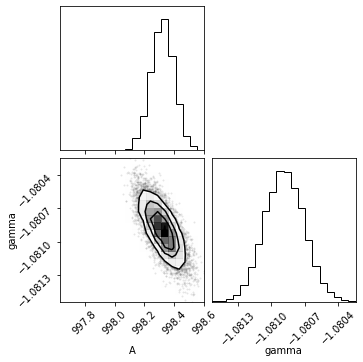

In [99]:
#Print best values and make corner plot
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

mcmc_res=np.zeros((ndim,3))

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    mcmc_res[i]=mcmc
    #A_mcmc=mcmc[1][0]
    #g_mcmc=mcmc[1][0]
    #txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    #txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    #display(Math(txt))

print("MCMC values")
print("A = %f + %f -%f" % (mcmc_res[0,1], mcmc_res[0,1]-mcmc_res[0,2], mcmc_res[0,1]-mcmc_res[0,0]))
print("gamma = %f + %f -%f" % (mcmc_res[1,1], mcmc_res[1,1]-mcmc_res[1,2], mcmc_res[1,1]-mcmc_res[1,0]))

labels=['A', 'gamma']
fig = corner.corner(
    flat_samples, labels=labels,
);

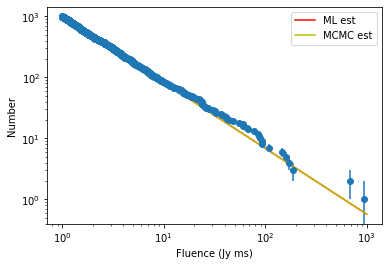

In [100]:
#Compare ML est and MCMC est with the input data
fdum=np.arange(1,1000,0.1)

py.errorbar(F, N, yerr=errN, fmt='o')
py.plot(fdum, A_ml*fdum**g_ml, 'r-', label='ML est')
py.plot(fdum, mcmc_res[0,1]*fdum**mcmc_res[1,1], 'y-', label='MCMC est')
py.legend()
py.xlabel('Fluence (Jy ms)')
py.ylabel('Number')
py.xscale('log')
py.yscale('log')

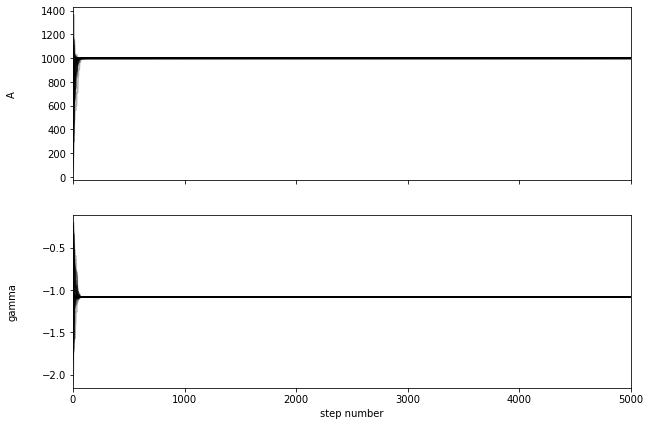

In [101]:
#Diagnostic plot on how quickly the values converge
fig, axes = py.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["A", "gamma"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");